# 0.3.3 La curva ROC (Receiver operating characteristic)

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle

from scipy import interp
from sklearn import datasets, svm
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../../../../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.3.3.1 La curva ROC (Receiver operating characteristic)

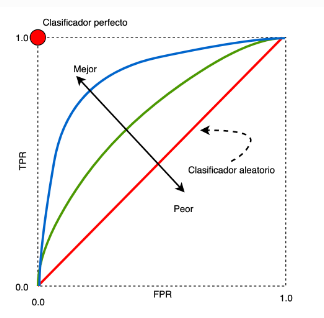

Es una gráfica que compara el desempeño de un clasificador binario cuando se varia la frontera de decisión. La curva se construye al graficar la tasa de verdaderos positivos (TPR, sensibilidad o recall), en el eje Y, vs la tasa de falsos positivos (FPR), en el eje X, al variar la frontera de decisión del clasificador.

Es decir, se expresa la TPR como una función de la FPR.

A partir de la siguiente matriz de confusión:

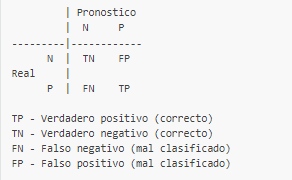

los valores a graficar se obtienen como:

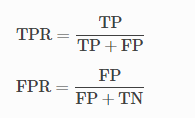

- La FPR representa la tasa de falsa alarma, esto es: la cantidad de Falsos Positivos sobre la totalidad de negativos.
- La TPR es la tasa de casos declarados como positivos, que verdaderamente presetan la condición.

De la gráfica, usualmente se computa el área bajo la curva. A mayor área, es mejor el clasificador.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [6]:
#
# Carga del dataset de datos
#
iris = datasets.load_iris()
X = iris.data
y = iris.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
#
# Se binariza la salida para generar tres columnas. La implementación
# está restringida al caso binario.
#
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
y[:5, :]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [8]:
#
# Adiciona nuevas variables aleatorias
#
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [9]:
#
# Conjuntos de entrenamiento y validación
#
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=0,
)

y_train[:10, :]

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [10]:
#
# Construye el clasificador que usa la estrategia OneVsRest
#
classifier = OneVsRestClassifier(
    svm.SVC(
        kernel="linear",
        probability=True,
        random_state=random_state,
    )
)


#
# decision_function: Return the distance of each sample from the decision
# boundary for each class.
#
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#
# Cálculo de la curva RO
#
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # -------------------------------------------------------------------------
    # fpr: Increasing false positive rates such that element i is the false
    #    positive rate of predictions with score >= thresholds[i].
    # tpr: Increasing true positive rates such that element i is the true
    #    positive rate of predictions with score >= thresholds[i].
    # thresholds: Decreasing thresholds on the decision function used to
    #   compute fpr and tpr.
    fpr[i], tpr[i], _ = roc_curve(
        # ---------------------------------------------------------------------
        # True binary labels, {-1, 1} or {0, 1}
        y_true=y_test[:, i],
        # ---------------------------------------------------------------------
        # Target scores, can either be probability estimates of the positive
        # class, confidence values, or non-thresholded measure of decisions (as
        # returned by “decision_function” on some classifiers).
        y_score=y_score[:, i],
    )

    # -------------------------------------------------------------------------
    # Compute Area Under the Curve (AUC) using the trapezoidal rule.
    roc_auc[i] = auc(
        x=fpr[i],
        y=tpr[i],
    )

In [11]:
#
# False positive rate
#
fpr

{0: array([0.        , 0.        , 0.        , 0.01851852, 0.01851852,
        0.03703704, 0.03703704, 0.05555556, 0.05555556, 0.07407407,
        0.07407407, 0.09259259, 0.09259259, 0.12962963, 0.12962963,
        0.14814815, 0.14814815, 0.2037037 , 0.2037037 , 0.27777778,
        0.27777778, 1.        ]),
 1: array([0.        , 0.        , 0.        , 0.02222222, 0.02222222,
        0.11111111, 0.11111111, 0.17777778, 0.17777778, 0.2       ,
        0.2       , 0.24444444, 0.24444444, 0.26666667, 0.26666667,
        0.37777778, 0.37777778, 0.42222222, 0.42222222, 0.48888889,
        0.48888889, 0.55555556, 0.55555556, 0.62222222, 0.62222222,
        0.64444444, 0.64444444, 0.66666667, 0.66666667, 0.73333333,
        0.73333333, 0.75555556, 0.75555556, 0.88888889, 0.88888889,
        1.        ]),
 2: array([0.        , 0.        , 0.        , 0.01960784, 0.01960784,
        0.07843137, 0.07843137, 0.09803922, 0.09803922, 0.11764706,
        0.11764706, 0.1372549 , 0.1372549 , 0.15686

In [12]:
#
# True positive rate
#
tpr

{0: array([0.        , 0.04761905, 0.14285714, 0.14285714, 0.19047619,
        0.19047619, 0.33333333, 0.33333333, 0.38095238, 0.38095238,
        0.61904762, 0.61904762, 0.66666667, 0.66666667, 0.76190476,
        0.76190476, 0.9047619 , 0.9047619 , 0.95238095, 0.95238095,
        1.        , 1.        ]),
 1: array([0.        , 0.03333333, 0.13333333, 0.13333333, 0.16666667,
        0.16666667, 0.2       , 0.2       , 0.26666667, 0.26666667,
        0.33333333, 0.33333333, 0.4       , 0.4       , 0.43333333,
        0.43333333, 0.5       , 0.5       , 0.56666667, 0.56666667,
        0.6       , 0.6       , 0.63333333, 0.63333333, 0.7       ,
        0.7       , 0.73333333, 0.73333333, 0.9       , 0.9       ,
        0.93333333, 0.93333333, 0.96666667, 0.96666667, 1.        ,
        1.        ]),
 2: array([0.        , 0.04166667, 0.125     , 0.125     , 0.25      ,
        0.25      , 0.29166667, 0.29166667, 0.33333333, 0.33333333,
        0.41666667, 0.41666667, 0.5       , 0.5    

In [13]:
roc_auc

{0: 0.9126984126984127, 1: 0.6037037037037037, 2: 0.7867647058823529}

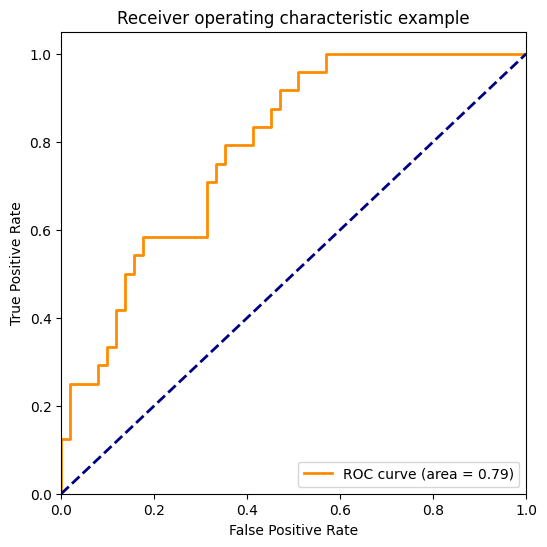

In [14]:
plt.figure(figsize=(6, 6))

plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("Receiver operating characteristic example")

plt.legend(loc="lower right")
plt.show()

In [14]:
print('ok_')

ok_
